# Emoji Prediction - ECS 171 Group Project

# Setting Up

We start by importing necessary libraries, and downloading the dataset from kaggle

In [9]:
# importing libraries
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import load_img

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import MaxPool2D, Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
import keras.utils as image


In [10]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d msambare/fer2013

In [ ]:
! unzip fer2013.zip;

# Data Exploration

Goes through the dataset and describes data by defining number of classes, # of images, and size of images. 


In [14]:
train_dir = './train/'
test_dir = './test/'

# image size
row, col = 48, 48
# number of image classes: angry, sad, etc
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

# number of observations
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       disgust  happy   sad  surprise  neutral  angry  fear
train      436   7215  4830      3171     4965   3995  4097
      disgust  happy   sad  surprise  neutral  angry  fear
test      111   1774  1247       831     1233    958  1024


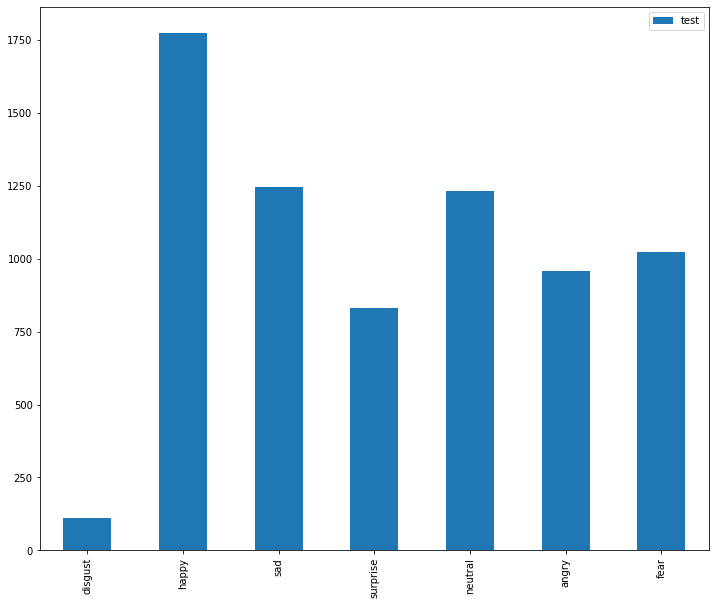

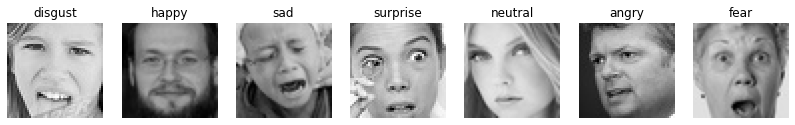

In [15]:
test_count.transpose().plot(kind='bar',figsize=(12, 10))

plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

# Data Preprocessing



In [16]:
shutil.rmtree( './train/disgust')
shutil.rmtree( './test/disgust')


In [17]:
# train dataset
images = []
labels = []
for subset in os.listdir(train_dir):
  image_list = os.listdir(os.path.join(train_dir,subset))  # all the names of images in the directory
  image_list = list(map(lambda x:os.path.join(subset,x),image_list))
  images.extend(image_list)
  labels.extend([subset]*len(image_list)) 

df = pd.DataFrame({"Images":images,"Labels":labels})      
df = df.sample(frac=1).reset_index(drop=True) # this will shuffle the data
samplesize = int(int(df.size)/14)  # sample size used for modelling 
print(samplesize)
df_train = df.head(samplesize)  

4039


In [18]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

In [19]:
train_generator = datagen.flow_from_dataframe(
    directory = train_dir, 
    dataframe=df_train,
    x_col="Images",
    y_col="Labels",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    target_size=(48,48), 
    class_mode="categorical", 
    color_mode="grayscale"
)

valid_generator=datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=train_dir,
    x_col="Images",
    y_col="Labels",
    subset="validation",
    color_mode="grayscale",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(48,48)
)

Found 3030 validated image filenames belonging to 6 classes.
Found 1009 validated image filenames belonging to 6 classes.


In [20]:
# test dataset
images = []
labels = []
for subset in os.listdir(test_dir):
  image_list = os.listdir(os.path.join(test_dir,subset))  # all the names of images in the directory
  image_list = list(map(lambda x:os.path.join(subset,x),image_list))
  images.extend(image_list)
  labels.extend([subset]*len(image_list)) 

df = pd.DataFrame({"Images":images,"Labels":labels})      
df = df.sample(frac=1).reset_index(drop=True) # To shuffle the data 
samplesize = int(int(df.size)/14)  # sample size used for modelling
print(samplesize)
df_test = df.head(samplesize) 

1009


In [21]:
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(
    directory = test_dir, 
    target_size=(48,48), 
    #class_mode="categorical", 
    class_mode=None,
    shuffle=False,
    color_mode="grayscale",
    dataframe = df_test,
    x_col="Images",
    y_col="Labels",
    batch_size=32,
    seed=42,
)

Found 1009 validated image filenames.


In [22]:
model= tf.keras.models.Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
    
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(6, activation='sigmoid'))
model.add(Dense(6, activation='softmax'))


model.compile(
    optimizer = Adam(), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [24]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
firstModel = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20
)

Epoch 1/20


<ipython-input-24-948cf81dab7a>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  firstModel = model.fit_generator(generator=train_generator,


94/94 [==============================] - 82s 875ms/step - loss: 0.7784 - accuracy: 0.7748 - val_loss: 1.6939 - val_accuracy: 0.3770
Epoch 2/20
94/94 [==============================] - 81s 864ms/step - loss: 0.8475 - accuracy: 0.7355 - val_loss: 1.7574 - val_accuracy: 0.3619
Epoch 3/20
94/94 [==============================] - 80s 852ms/step - loss: 0.8584 - accuracy: 0.7322 - val_loss: 1.6886 - val_accuracy: 0.4042
Epoch 4/20
94/94 [==============================] - 80s 851ms/step - loss: 0.7143 - accuracy: 0.7982 - val_loss: 1.9006 - val_accuracy: 0.3216
Epoch 5/20
94/94 [==============================] - 81s 860ms/step - loss: 0.6617 - accuracy: 0.8109 - val_loss: 1.9329 - val_accuracy: 0.3115
Epoch 6/20
94/94 [==============================] - 80s 847ms/step - loss: 0.6148 - accuracy: 0.8269 - val_loss: 1.7294 - val_accuracy: 0.4274
Epoch 7/20
94/94 [==============================] - 80s 855ms/step - loss: 0.5378 - accuracy: 0.8572 - val_loss: 1.7035 - val_accuracy: 0.4335
Epoch 8/20

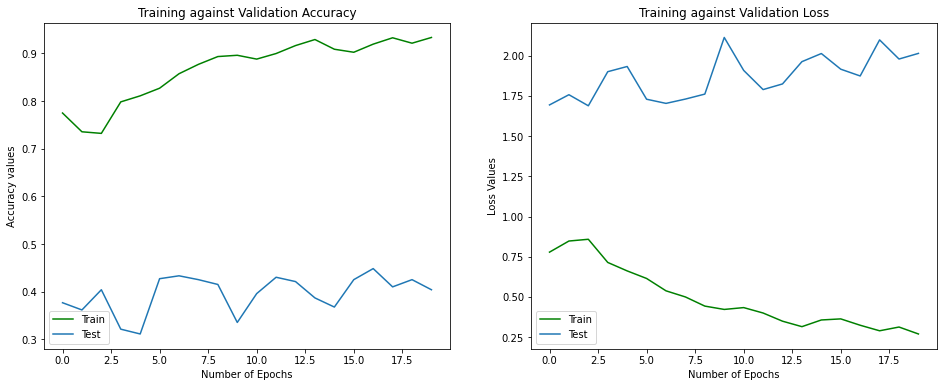

In [26]:
figure, axis = plt.subplots(1,2)
figure.set_size_inches(16,6)

train_ACC = firstModel.history['accuracy']
train_loss = firstModel.history['loss']

axis[0].plot(firstModel.history['accuracy'], color = "green")
axis[0].plot(firstModel.history['val_accuracy'])
axis[0].set_xlabel('Number of Epochs')
axis[0].set_ylabel('Accuracy values')
axis[0].set_title('Training against Validation Accuracy')
axis[0].legend(['Train', 'Test'], loc = 'lower left')

axis[1].plot(firstModel.history['loss'], color = "green")
axis[1].plot(firstModel.history['val_loss'])
axis[1].set_title('Training against Validation Loss')
axis[1].set_xlabel('Number of Epochs')
axis[1].set_ylabel('Loss Values')
axis[1].set_title('Training against Validation Loss')
axis[1].legend(['Train', 'Test'], loc ='lower left')

plt.show()

In [27]:
model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_TEST)

<ipython-input-27-01f81cad14e1>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_TEST)


[2.0249788761138916, 0.4022177457809448]

In [28]:
test_generator.reset()
pred=model.predict(test_generator, steps=STEP_SIZE_TEST)

31/31 [==============================] - 7s 206ms/step


In [29]:
predicted_class_indices=np.argmax(pred,axis=1)

In [30]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]


In [31]:
train_loss, train_ACC = model.evaluate(train_generator)
test_loss, test_ACC   = model.evaluate(valid_generator)
print("The train accuracy = {:.3f} , test accuracy = {:.3f}".format(train_ACC*100, test_ACC*100))

32/32 [==============================] - 6s 199ms/step - loss: 2.0223 - accuracy: 0.4024
The train accuracy = 97.558 , test accuracy = 40.238


##### Applying the model on a random image to test it.

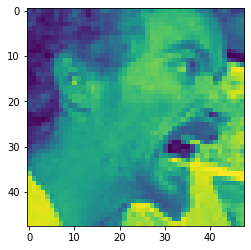

In [32]:
img = image.load_img("./test/angry/PrivateTest_10304478.jpg", target_size = (48,48), color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)

In [33]:
label_dict = {0:'Angry',1:'Fear',2:'Happy',3:'Neutral',4:'Sad',5:'Surprise'}


In [34]:
img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,48,48,1)
result = model.predict(img)
result = list(result[0])
print(result)

1/1 [==============================] - 0s 160ms/step
[0.4031306, 0.39656538, 0.009515647, 0.12312976, 0.024715204, 0.042943463]


In [35]:
img_index = result.index(max(result))
print(label_dict[img_index])
plt.show()

Angry
